### The purpose of this notebook to create a EDA for the Kepler exoplanet discovery dataset. We want to use the information available to predict whether the objects found are planets or not. 

## The first step is to load the dataset and inspect the data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
planet_dataset = pd.read_csv('../data/cumulative.csv')
print(planet_dataset.head(10))
print(planet_dataset.info)
print(planet_dataset.describe)
print(planet_dataset.columns)

# Check for null values in the dataset

missing = planet_dataset.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])

   rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2      3  10811496  K00753.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   
5      6  10872983  K00756.01  Kepler-228 d       CONFIRMED        CANDIDATE   
6      7  10872983  K00756.02  Kepler-228 c       CONFIRMED        CANDIDATE   
7      8  10872983  K00756.03  Kepler-228 b       CONFIRMED        CANDIDATE   
8      9   6721123  K00114.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
9     10  10910878  K00757.01  Kepler-229 c       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  ...  \
0      1.000              0              0           

### With a dataset with 50 columns we definitley want to do some trimming and make the dataset a bit more manageable.There are plenty of columns with identifiers that dont help with our analysis ie. ('kepler_name'). There are also a large amount of columns with error margin data that is not useful. I am going to start the cleaning by selecting a few columns that will be crutial for analysis in detecting exoplanets.

### Selected Features for Analysis

Below are the features retained for analysis and modeling, along with their descriptions:

| Feature         | Description |
|----------------|-------------|
| `kopoi_name`   | Identifier information |
| `koi_prad`     | Estimated radius of the planet (in Earth radii) |
| `koi_period`   | Orbital period of the planet (in days) |
| `koi_steff`    | Effective temperature of the host star (in Kelvin) |
| `koi_slogg`    | Log surface gravity of the host star (in cgs units) |
| `koi_srad`     | Radius of the host star (in Solar radii) |
| `koi_teq`      | Estimated equilibrium temperature of the planet (in Kelvin) |
| `koi_depth`    | Transit depth (the amount of light blocked during transit) |
| `koi_duration` | Duration of the transit (in hours) |
| `koi_score`    | Disposition score â€” NASA's confidence level in candidate status |
| `koi_disposition` | Final classification â€” CONFIRMED, FALSE POSITIVE, or CANDIDATE |


In [48]:
columns_to_keep = ['kepoi_name', 'koi_prad', 'koi_period', 'koi_steff', 'koi_slogg', 'koi_srad',
'koi_teq', 'koi_depth', 'koi_duration', 'koi_score', 'koi_disposition']

planet_dataset = planet_dataset[columns_to_keep]
planet_dataset = planet_dataset.dropna()

print(planet_dataset.info())
print(planet_dataset.head(10))

planet_dataset['koi_disposition'].value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 7995 entries, 0 to 9563
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepoi_name       7995 non-null   object 
 1   koi_prad         7995 non-null   float64
 2   koi_period       7995 non-null   float64
 3   koi_steff        7995 non-null   float64
 4   koi_slogg        7995 non-null   float64
 5   koi_srad         7995 non-null   float64
 6   koi_teq          7995 non-null   float64
 7   koi_depth        7995 non-null   float64
 8   koi_duration     7995 non-null   float64
 9   koi_score        7995 non-null   float64
 10  koi_disposition  7995 non-null   object 
dtypes: float64(9), object(2)
memory usage: 749.5+ KB
None
  kepoi_name  koi_prad  koi_period  koi_steff  koi_slogg  koi_srad  koi_teq  \
0  K00752.01      2.26    9.488036     5455.0      4.467     0.927    793.0   
1  K00752.02      2.83   54.418383     5455.0      4.467     0.927    443.0   
2  K

koi_disposition
FALSE POSITIVE    3922
CONFIRMED         2281
CANDIDATE         1792
Name: count, dtype: int64

### Exploratory Analysis

We will use different plots to understand the distribution of our data as well as the correltion between different columns. This will help us decide what is useful for our model. 

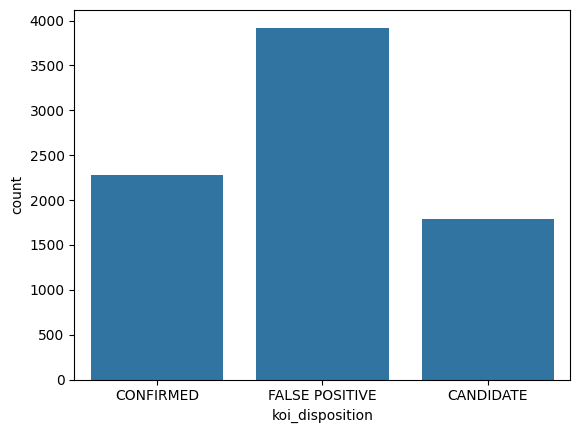

In [49]:
sns.countplot(data=planet_dataset, x='koi_disposition')

numeric_planet_dataset = planet_dataset.drop(columns=['kepoi_name', 'koi_disposition'])

### As we can see, the koi_disposition is distrubuted with an ovious mode of False Positive and about half of the time we get a confirmed planet. For now, we are going to ignore the entries with candidate, since we need more in order to classify them correctly. For now, we are going to train our model on confirmed and false positve, then later use our model to classify the candidate class. 

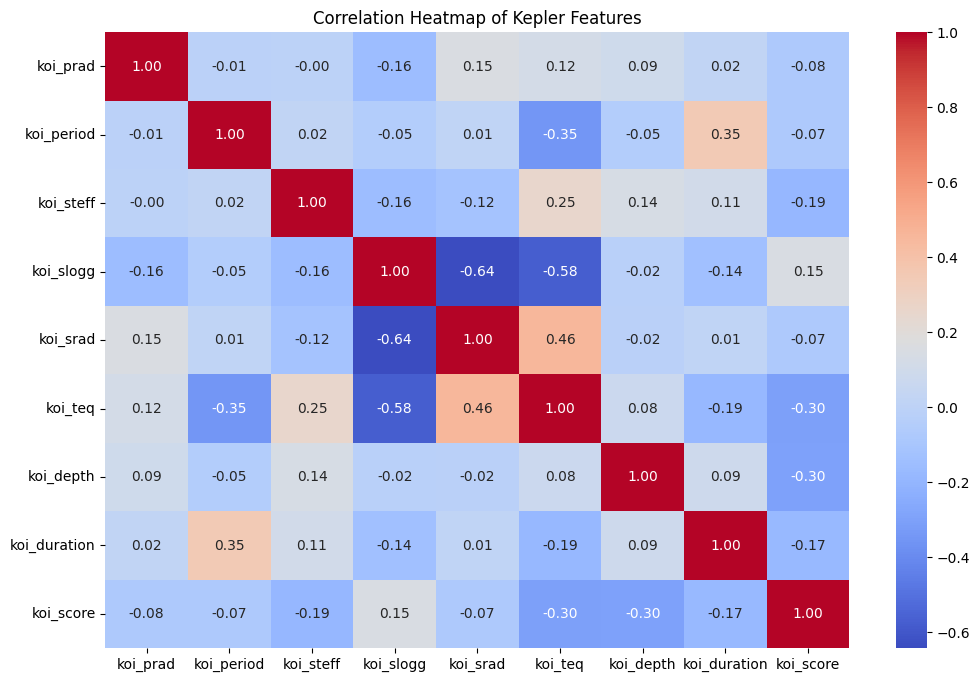

In [50]:

# Create the correlation matrix
corr_matrix = numeric_planet_dataset.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Kepler Features')
plt.show()

We are going to explore the correlation matrix to find some helpful insights about the planet data that might lead to classifying their koi_disposition values. 

Here are the relevant labels and what they mean to help us

| Feature         | Description |
|----------------|-------------|
| `koi_prad`     | Estimated radius of the planet (in Earth radii) |
| `koi_period`   | Orbital period of the planet (in days) |
| `koi_steff`    | Effective temperature of the host star (in Kelvin) |
| `koi_slogg`    | Log surface gravity of the host star (in cgs units) |
| `koi_srad`     | Radius of the host star (in Solar radii) |
| `koi_teq`      | Estimated equilibrium temperature of the planet (in Kelvin) |
| `koi_depth`    | Transit depth (the amount of light blocked during transit) |
| `koi_duration` | Duration of the transit (in hours) |
| `koi_score`    | Disposition score â€” NASA's confidence level in candidate status |


The correlation heatmap above shows how numerical features in the Kepler exoplanet dataset relate to one another. Here are some notable observations:

 * Surface gravity (koi_slogg) and stellar radius (koi_srad) show a strong negative correlation (-0.64). This makes sense physicallyâ€”larger stars generally have lower surface gravity.

 * Stellar effective temperature (koi_steff) is negatively correlated with koi_slogg (-0.16) and positively correlated with equilibrium temperature (koi_teq) (0.25), indicating that hotter stars often result in hotter planets.

 * Equilibrium temperature (koi_teq) and stellar radius (koi_srad) are moderately correlated (0.46), suggesting that larger stars may contribute to higher planetary temperatures.

 * koi_score, which represents the model's confidence in the planetary nature of the candidate, has negative correlations with several features, including:

    - koi_teq: -0.30

    - koi_depth: -0.30

    - koi_duration: -0.17

    - koi_steff: -0.19

These negative correlations may indicate that deeper or shorter transits and higher equilibrium temperatures are associated with lower confidence scores.

Overall, the correlations are relatively weak across most features, suggesting that multiple variables together may be more informative than any single one individually. This motivates the use of machine learning models that can capture these complex relationships.

Next I am going to encode the koi_disposition and see if I can find any useful information when using that in our EDA. 


/var/folders/28/d2b1gshn5v94b_tk47b_x53r0000gn/T/ipykernel_67716/1512292820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_planet_dataset['binary_disposition'] = encoded_planet_dataset['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)


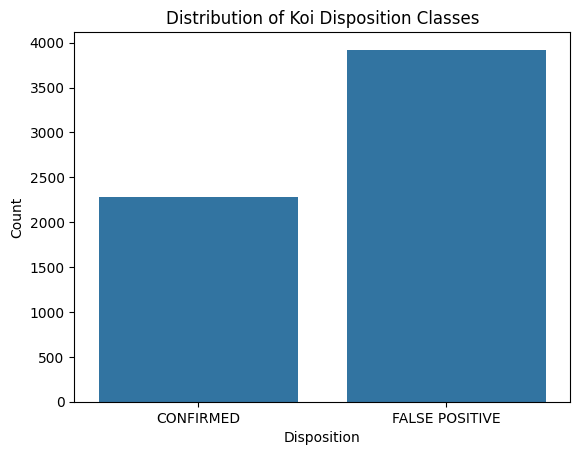

binary_disposition
0    0.632275
1    0.367725
Name: proportion, dtype: float64


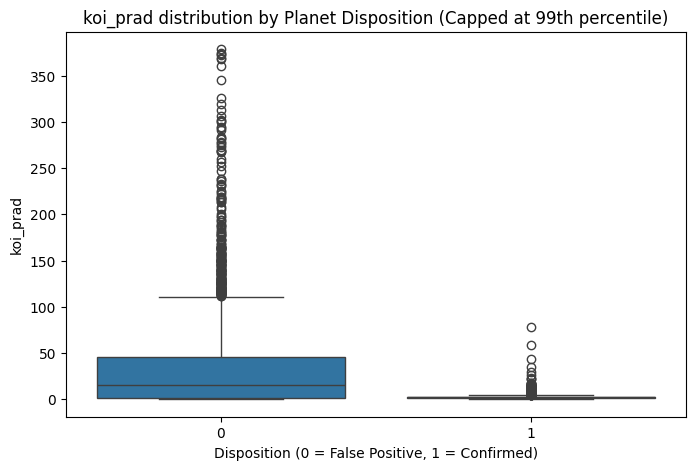

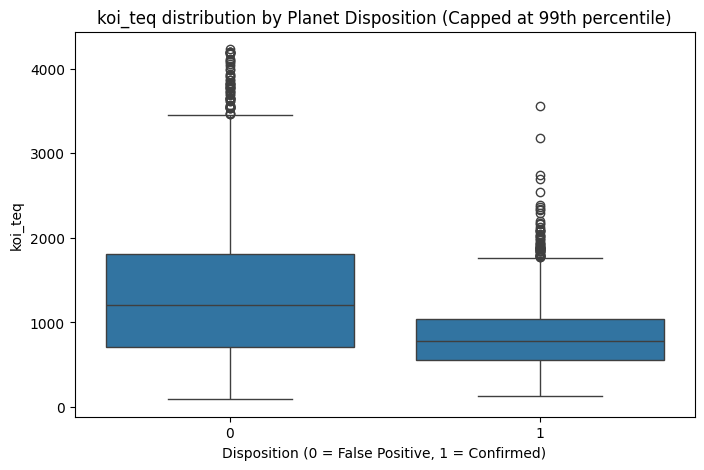

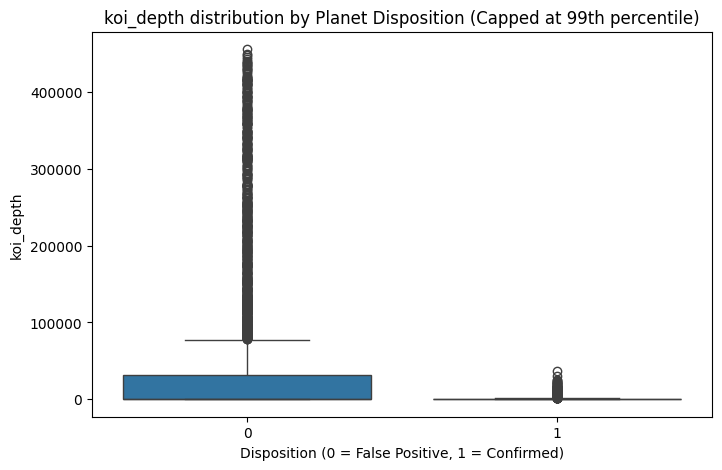

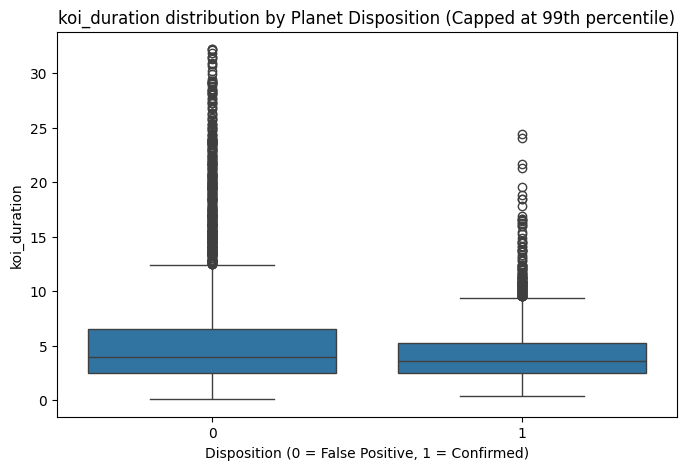

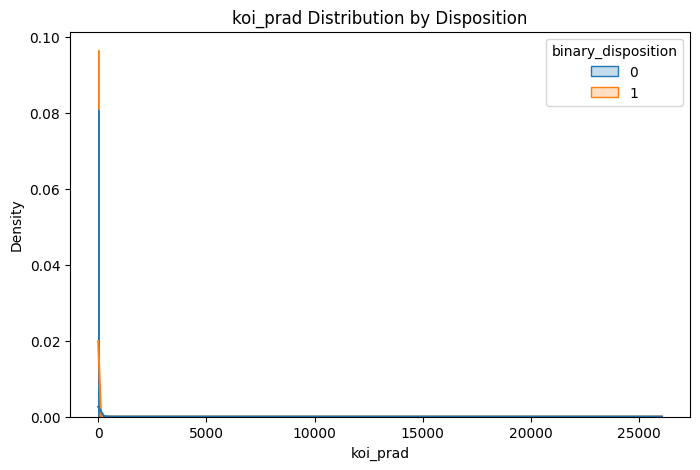

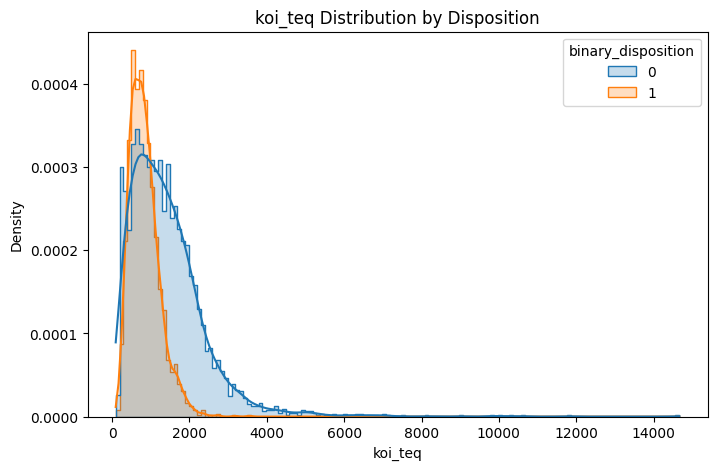

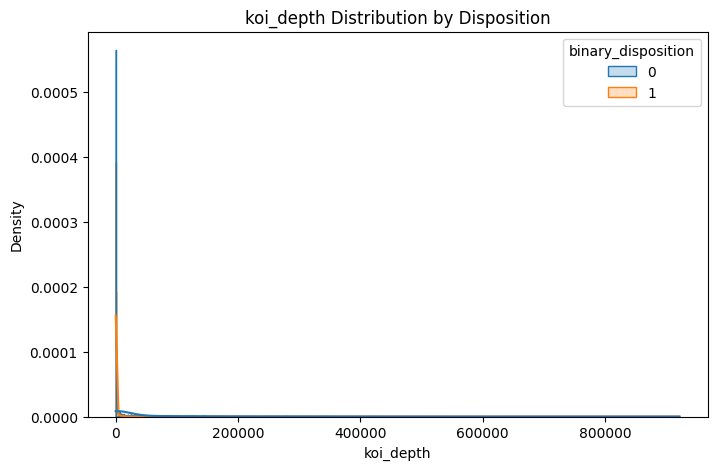

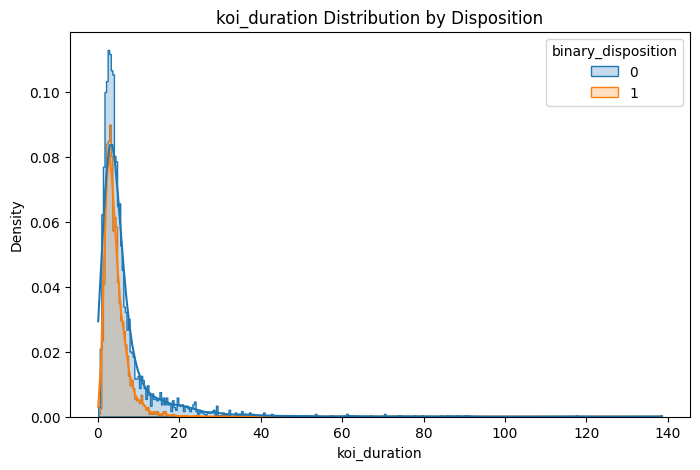

In [70]:
encoded_planet_dataset = planet_dataset[planet_dataset['koi_disposition'] != 'CANDIDATE']
encoded_planet_dataset['binary_disposition'] = encoded_planet_dataset['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

sns.countplot(data=encoded_planet_dataset, x='koi_disposition')
plt.title('Distribution of Koi Disposition Classes')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.show()

print(encoded_planet_dataset['binary_disposition'].value_counts(normalize=True))

features = ['koi_prad', 'koi_teq', 'koi_depth', 'koi_duration']
for feature in features:
    plt.figure(figsize=(8, 5))
    
    # Cap outliers at 99th percentile
    upper = encoded_planet_dataset[feature].quantile(0.99)
    filtered_data = encoded_planet_dataset[encoded_planet_dataset[feature] <= upper]
    
    sns.boxplot(x='binary_disposition', y=feature, data=filtered_data)
    plt.title(f'{feature} distribution by Planet Disposition (Capped at 99th percentile)')
    plt.xlabel('Disposition (0 = False Positive, 1 = Confirmed)')
    plt.ylabel(feature)
    plt.show()


for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=encoded_planet_dataset, x=feature, hue='binary_disposition', kde=True, element='step', stat='density')
    plt.title(f'{feature} Distribution by Disposition')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()



### ðŸ§ª Feature Distribution Analysis by Planet Disposition

To better understand how individual features relate to whether a Kepler Object of Interest (KOI) is a **confirmed exoplanet (1)** or a **false positive (0)**, we visualized four key attributes using boxplots and histograms.

#### 1. `koi_prad` (Planet Radius)
- Most confirmed planets and false positives have small radii, but there are extreme outliers, especially among false positives.
- When capped at the 99th percentile, the distributions are easier to compare: confirmed planets tend to have slightly smaller and more consistent radii.
- Histograms show some overlap, suggesting this feature alone may not be highly predictive.

#### 2. `koi_teq` (Equilibrium Temperature)
- Confirmed planets often have a wider and slightly hotter temperature distribution compared to false positives.
- The histogram reveals more confirmed planets at higher temperatures, indicating a possible relationship between higher `koi_teq` and confirmation.

#### 3. `koi_depth` (Transit Depth)
- The boxplots show significant outliers in depth for both classes, but especially false positives.
- After capping, we notice that confirmed planets tend to have lower transit depths, supporting the idea that extreme transit depths may be more indicative of false detections.

#### 4. `koi_duration` (Transit Duration)
- Distribution of transit duration appears similar across both classes.
- The histograms do not show a dramatic shift, suggesting this feature might not carry strong predictive power on its own.

---

### ðŸ“Œ Summary:
- `koi_prad`, `koi_teq`, and `koi_depth` show the most notable differences between confirmed planets and false positives.
- `koi_duration` has limited class separation but may still be useful in combination with other features.
- Visualizing features in this way helps validate which inputs could contribute most effectively to a binary classification model.
